In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [47]:
stl_path = "../data/stl_energy_production_with_weather.csv"
hp_path = "../data/hp_energy_production_with_weather.csv"

stl_df = pd.read_csv(stl_path)
hp_df = pd.read_csv(hp_path)

stl_df["Date"] = pd.to_datetime(stl_df["Date"])
hp_df["Date"] = pd.to_datetime(hp_df["Date"])

stl_df["Month"] = stl_df["Date"].dt.month
hp_df["Month"] = hp_df["Date"].dt.month

# Feature Engineering
for df in [stl_df, hp_df]:    
    df["WaterFlow_Diff_1d"] = df["Water_Flow_m3_s"].diff(1)
    df["WaterFlow_Diff_7d"] = df["Water_Flow_m3_s"].diff(7)

    df["WaterFlow_3day_avg"] = df["Water_Flow_m3_s"].rolling(3).mean()
    df["WaterFlow_7day_avg"] = df["Water_Flow_m3_s"].rolling(7).mean()

    df["Temp_Deviation"] = df["avgtempC"] - df["avgtempC"].mean()
    df["WaterFlow_Humidity"] = df["Water_Flow_m3_s"] * df["humidity"]

    df["month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

    df["Normalized_Efficiency"] = (df['Water_Flow_m3_s'] - df['Water_Flow_m3_s'].mean()) / df['Water_Flow_m3_s'].std()

    df["Prev_Day_Efficiency"] = df['Water_Flow_m3_s'].shift(1)
    df["Prev_Week_Efficiency"] = df['Water_Flow_m3_s'].shift(7)


stl_df.dropna(inplace=True)
hp_df.dropna(inplace=True)

In [42]:
stl_updated_path = "../processed_data/stl_energy_production_with_engineered_features_1.csv"
hp_updated_path = "../processed_data/hp_energy_production_with_engineered_features_1.csv"

stl_df.to_csv(stl_updated_path, index=False)
hp_df.to_csv(hp_updated_path, index=False)

In [40]:
print("STL Data Preview:")
print(stl_df.head())

print("HP Data Preview:")
print(hp_df.head())


STL Data Preview:
         Date   Station  Water_Flow_m3_s  avgtempC  totalprecipMM  humidity  \
7  2022-01-04  Amberd 3     18022.752294        -2            0.4        56   
8  2022-01-04  Amberd 3     18147.491347        -2            0.4        56   
9  2022-01-05  Amberd 3     18441.472148        -2            0.0        59   
10 2022-01-05  Amberd 3     16296.513761        -2            0.0        59   
11 2022-01-05  Amberd 3     16646.615149        -2            0.0        59   

    pressureMB  Month  WaterFlow_Diff_1d  WaterFlow_Diff_7d  \
7         1020      1       -2104.887074        -433.861103   
8         1020      1         124.739054        1950.794100   
9         1025      1         293.980801        1847.690973   
10        1025      1       -2144.958387        -611.717771   
11        1025      1         350.101387        2234.872030   

    WaterFlow_3day_avg  WaterFlow_7day_avg  Temp_Deviation  \
7         17644.706685        16720.653304       -15.54558   
8   

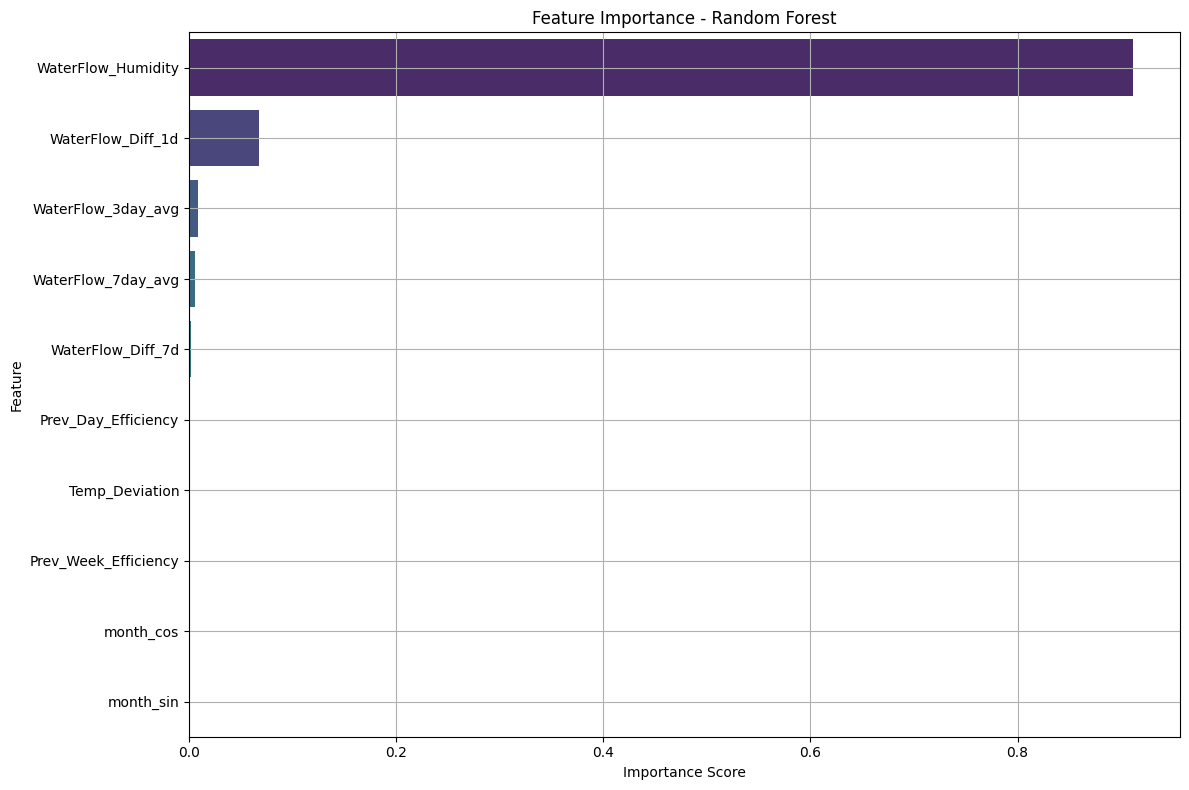

In [48]:
features = [
    "WaterFlow_Diff_1d", "WaterFlow_Diff_7d", "WaterFlow_3day_avg", "WaterFlow_7day_avg",
    "Temp_Deviation", "WaterFlow_Humidity",
    "month_sin", "month_cos",
    "Prev_Day_Efficiency", "Prev_Week_Efficiency"
]
target = "Normalized_Efficiency"

X = hp_df[features]
y = hp_df[target]

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)

plt.tight_layout()
plt.savefig("../feature_importance_hp.png", dpi=150)
plt.show()
plt.close()